In [1]:
import shutup
import torch
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tsgcn.simulation import MsprimeSimulation, run_sims
from tsgcn.util import get_idle_gpu
from tsgcn.data import TreeSequenceData, TreeSequencesDataset, windowed_div_from_ts, compute_ys
from tsgcn.model import BiGCNModel, BiGCNEncoder

import tskit

shutup.please()

/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_geometric/typing.py:42: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/torch_sparse/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
/home/murillor/miniconda3/envs/gcn/lib/python3.10/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is depr

In [2]:
# this device variable will get used later during training
device = torch.device(f"cuda:{get_idle_gpu()}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
## CONSTANTS
seed = 11379
num_reps = 1_000
sp_name = "HomSap"
chrom = None
length = 1_000_000
model_name ="OutOfAfrica_3G09"
sample_size=10
num_windows = 100
HomSap_chr13_OOA = MsprimeSimulation(seed, num_reps, sp_name, model_name, "data/raw/", chrom, length, sample_size, n_workers=512)
breaks = np.linspace(0, HomSap_chr13_OOA.contig.length, num_windows+1)

In [4]:
run_sims(HomSap_chr13_OOA)

In [5]:
# Just exploring the output of convert_tseq
from tsgcn.util import convert_tseq
ts=tskit.load(HomSap_chr13_OOA.ts_paths[0])
eix, ei, nf, sq = convert_tseq(ts)
a=TreeSequenceData(edge_index=eix, edge_interval=ei, x = nf, sequence_length=sq)

In [6]:
# Importing our dataset
dataset = TreeSequencesDataset("data/", HomSap_chr13_OOA.sims_path,seeds=HomSap_chr13_OOA.seed_array, y_name="windowed-diversity")

In [7]:
compute_ys(dataset, windowed_div_from_ts, "windowed-diversity", num_windows=num_windows, n_workers=256)

In [8]:
def node_num_child(ts):
    stats = np.zeros((ts.num_nodes, ), dtype=np.float32)
    for tree in ts.trees():
        for u in tree.nodes():
            stats[u] += tree.num_children(u)
    return torch.FloatTensor(stats)

In [9]:
dataset.len()

1000

In [10]:
t = BiGCNEncoder(1,4)
a = t(dataset[0])

In [11]:
from torch.utils.data import random_split

torch.manual_seed(123)
train_set, valid_set, test_set = random_split(dataset,[70*dataset.len()//100, 15*dataset.len()//100, 15*dataset.len()//100])

trainloader = DataLoader(train_set, batch_size=1, shuffle=True)
validloader = DataLoader(valid_set, batch_size=1, shuffle=True)
testloader = DataLoader(test_set, batch_size=1, shuffle=True)

In [12]:
def get_y(batch):
    #return batch.x[:,0].unsqueeze(1)
    return batch.y.unsqueeze(1)

In [13]:
next(iter(validloader))

TreeSequenceDataBatch(x=[1537, 1], edge_index=[2, 8245], edge_interval=[2, 8245], sequence_length=[1], y=[100], batch=[1537], ptr=[2])

In [14]:
torch.manual_seed(1793335)
model = BiGCNModel(device, num_encoder_in_features=dataset.num_features, breaks=breaks, pooling="windowed_sum")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
num_epochs=10
criterion = torch.nn.MSELoss()

for epoch in range(num_epochs):
    epoch_loss = 0
    model.train()
    num_batches = 0
    for batch in trainloader:
        num_batches+=1
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        #print(output.shape, batch.x[:,0].unsqueeze(1).shape)
        loss = criterion(output,get_y(batch))
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
    
    train_avg_loss = epoch_loss / num_batches
    val_loss = 0
    model.eval()
    num_batches = 0
    for batch in validloader:
        num_batches+=1
        batch.to(device)
        output = model(batch)
        loss = criterion(output,get_y(batch))
        val_loss += loss.item()
    val_avg_loss = val_loss/num_batches
    
    
    print(f"Epochs: {epoch} | epoch avg. loss: {train_avg_loss:.8f} | validation avg. loss: {val_avg_loss:.8f}")

Epochs: 0 | epoch avg. loss: 567.57234976 | validation avg. loss: 0.30414978
Epochs: 1 | epoch avg. loss: 0.08937932 | validation avg. loss: 0.07998774
Epochs: 2 | epoch avg. loss: 0.07711540 | validation avg. loss: 0.07970192
Epochs: 3 | epoch avg. loss: 0.07709858 | validation avg. loss: 0.07993611
Epochs: 4 | epoch avg. loss: 0.07718662 | validation avg. loss: 0.08336697
Epochs: 5 | epoch avg. loss: 0.07719471 | validation avg. loss: 0.07997558
Epochs: 6 | epoch avg. loss: 0.07732970 | validation avg. loss: 0.08044459
Epochs: 7 | epoch avg. loss: 0.07733385 | validation avg. loss: 0.08054956
Epochs: 8 | epoch avg. loss: 0.07756684 | validation avg. loss: 0.08020064
Epochs: 9 | epoch avg. loss: 0.07760937 | validation avg. loss: 0.08085232


In [15]:
model.eval()
predictions = []
real = []

for batch in testloader:
    
    output = model(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(get_y(batch).detach().cpu().numpy())

predictions = np.concatenate(predictions)
real = np.concatenate(real)

In [16]:
model.eval()

BiGCNModel(
  (encoder): BiGCNEncoder(
    (conv_f1): GCNConv(1, 16)
    (conv_f2): GCNConv(16, 8)
    (conv_b1): GCNConv(1, 16)
    (conv_b2): GCNConv(16, 8)
    (batch_norm_f): BatchNorm1d(8, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (batch_norm_b): BatchNorm1d(8, eps=1e-05, momentum=0.3, affine=True, track_running_stats=True)
    (lin): Linear(in_features=16, out_features=8, bias=True)
  )
  (lin1): Linear(in_features=8, out_features=4, bias=True)
  (lin2): Linear(in_features=4, out_features=1, bias=True)
)

In [17]:
predictions.shape

(15000, 1)

In [18]:
real.shape

(15000, 1)

In [19]:
batch = next(iter(testloader))

In [20]:
batch.to(device)
output = model(batch)
criterion(output, get_y(batch))

tensor(0.0954, device='cuda:0', grad_fn=<MseLossBackward0>)

Visualizing `Predicted~Observed` diversity within a single tree sequence

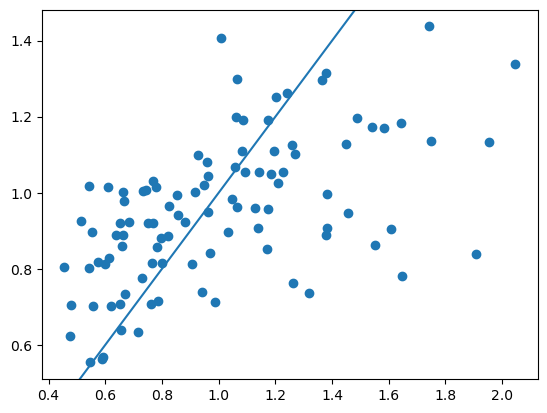

In [21]:
plt.scatter(get_y(batch).detach().cpu().numpy(), output.detach().cpu().numpy())
plt.axline((0.7,0.7), slope=1)

Now across all windows and tree sequences

In [22]:
import scipy.stats

In [23]:
# calculate r^2 of real and predictions
scipy.stats.pearsonr(real.flatten(), predictions.flatten())[0]**2

0.2823721427316364

Text(0.5, 0, 'Observed diversity')

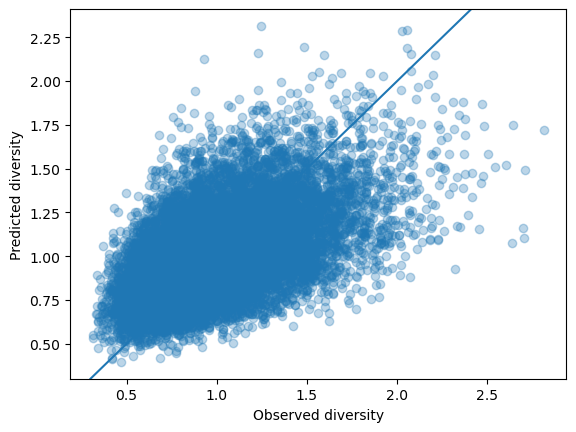

In [24]:


plt.scatter(real, predictions, alpha=0.3)
plt.axline((0.7,0.7), slope=1)

plt.ylabel('Predicted diversity')
plt.xlabel('Observed diversity')